In [79]:
import seaborn as sn
import random as rd
import itertools
import numpy as np
import warnings
import scipy
import plotly.graph_objects as go
import plotly.express as px 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.svm as svm
from tqdm import tqdm
from sklearn import ensemble , model_selection, metrics ,datasets,tree,linear_model
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score,roc_curve, auc,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV,cross_val_score, cross_val_predict,train_test_split
from sklearn import preprocessing,datasets
from sklearn.preprocessing import StandardScaler, MaxAbsScaler,normalize,label_binarize
from sklearn.feature_selection import SelectFromModel
from scipy.signal import savgol_filter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import OneClassSVM,LinearSVC
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge, LogisticRegression, LinearRegression, RidgeCV
from itertools import combinations  





def rubberband_corr(z):
        x = np.arange(0, z.shape[1],1)
        n = len(x)
        Y = z
        [m , n] = np.shape(Y)
        for i in range(int(m)):
            y = Y[i , :]
            
            if sum(np.isnan(y)) > 0:
                continue
            o = []
            for i in range(int(n/48)):
                time = y[48*i:48*(i+1)]
                a = (np.where(time == time.min())[0])
                #print(time)
                #print(np.where(time == time.min()))
                o.append(((a) + 48*i)[0])
            Y = np.vstack((Y, y - np.interp(x, x[o], y[o])))
                
        return Y[m:, :]*(Y[m:, :] > 0)

def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return output_data

def minmax_f(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.min(input_data[i,:])) / (np.max(input_data[i,:])-np.min(input_data[i,:]))
    return output_data
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()    

    
cutboard = [200] * 7

warnings.filterwarnings("ignore")




# Data

In [80]:
data = [[] ]* 6
x_axis = np.array(pd.read_csv('x_axis.csv')[220:]).reshape(1,len(np.array(pd.read_csv('x_axis.csv')[220:]))*2)
for i in range(6):
    data[i] = pd.read_csv(r'C:\Users\safiu\exp_%i.csv'%i)






In [81]:
# препроцессинг
all_data = []
for  k in [data[i] for i in range(6)]:
    df = (np.array(k[k.columns[:-3]])[:,220:]) # Обрезание ненужного диапазона 
    df = savgol_filter(df,15,3)  # сглаживание
    df = snv(df) # нормировка по объекту
    df = rubberband_corr(df)  

    df =pd.DataFrame(df)
    df['label']  =list(k.label)
    df['concentr'] = list(k.concentr)
    df['conc'] = list(k.conc)
    valid =  df[(df['concentr']==11) | (df['concentr']==8)]
    all_data.append(df)

val_set = all_data[5].query('concentr == 8 or concentr== 11')

all_data[5] = all_data[5][all_data[5]['concentr'] !=100]        # убираю ненужные объекты
all_data[5] = all_data[5][all_data[5]['concentr'] !=8]
all_data[5] = all_data[5][all_data[5]['concentr'] !=11]


# Regression

In [82]:
X_train, X_test,y_train,y_test=train_test_split(all_data[5][all_data[5].columns[:-3]],  all_data[5].concentr,
                                  test_size = 0.2, stratify = all_data[5].concentr, random_state = 42 )

In [83]:
# Augmentation
noise = np.random.normal(0, 0.1*np.mean(np.std(X_train)), X_train.shape)
new_signal = X_train + noise
X_train =pd.DataFrame(X_train)
new_signal =pd.DataFrame(new_signal)
X_train = pd.concat((X_train,new_signal))
y_train = np.concatenate((y_train,y_train)) 

## "Concentration" cross validation

In [84]:
for alpha in np.logspace(-6,6,30):
            model_lasso = SelectFromModel(Lasso(alpha = alpha).fit(X_train, y_train), prefit=True)
            X_train_1 = model_lasso.transform(X_train)
            if X_train_1.shape[1]==0:
                continue
            X_test_1 = model_lasso.transform(X_test)
            clf = RidgeCV(alphas=np.logspace(-6,6,30), cv = 5).fit(X_train_1, y_train)
            clf.score(X_train_1, y_train)
            y_pred = clf.predict(X_test_1)
            error_test = mean_squared_error(y_test, y_pred, squared = False)
            if clf.best_score_>0.93 and error_test < 2:
#                 plt.scatter(y_test, y_pred)
#                 plt.show()
                print('l1_alpha:',alpha, ',   l2_alpha: ', clf.alpha_)
                print("train r^2: " ,clf.best_score_)
                print ('test r^2 : ',r2_score(y_test, y_pred),',     test RMSE: ', error_test )






l1_alpha: 0.0020433597178569417 ,   l2_alpha:  0.013738237958832637
train r^2:  0.9799359463200975
test r^2 :  0.9369400231672462 ,     test RMSE:  1.9770894615787444
l1_alpha: 0.005298316906283708 ,   l2_alpha:  0.013738237958832637
train r^2:  0.9706231426741138
test r^2 :  0.9478809641267312 ,     test RMSE:  1.7974118658837914


## Augmentation parameter check

In [95]:
# for std_coef in tqdm(np.linspace(0,1,20)):
#     X_train, X_test,y_train,y_test=train_test_split(all_data[5][all_data[5].columns[:-3]],  all_data[5].concentr,
#                                       test_size = 0.2, stratify = all_data[5].concentr, random_state = 42 )
#     min_error_test = 2
#     noise = np.random.normal(np.mean(np.mean(X_train)), std_coef*np.mean(np.std(X_train)), X_train.shape)
#     new_signal = X_train + noise
#     X_train =pd.DataFrame(X_train)
#     new_signal =pd.DataFrame(new_signal)
#     X_train = pd.concat((X_train,new_signal))
#     y_train = np.concatenate((y_train,y_train))    
#     for alpha in np.logspace(-6,6,30):        #цикл по параметру для l1 отбора признаков
#                 model_lasso = SelectFromModel(Lasso(alpha = alpha).fit(X_train, y_train), prefit=True)
#                 X_train_1 = model_lasso.transform(X_train)
#                 if X_train_1.shape[1]==0:
#                     continue
#                 X_test_1 = model_lasso.transform(X_test)
#                 clf = RidgeCV(alphas=np.logspace(-6,6,30), cv = 5).fit(X_train_1, y_train)
#                 clf.score(X_train_1, y_train)
#                 y_pred = clf.predict(X_test_1)
#                 error_test = mean_squared_error(y_test, y_pred, squared = False)
#                 if error_test<min_error_test:
#                     min_error_test = error_test
#                 if clf.best_score_>0.9 and error_test <= min_error_test:
#                     plt.scatter(y_test, y_pred)
#                     plt.show()
#                     print('l1_alpha:',alpha, ',   l2_alpha: ', clf.alpha_)
#                     print("train r^2: " ,clf.best_score_, std_coef)
#                     print ('test r^2 : ',r2_score(y_test, y_pred),',     test RMSE: ', error_test )



In [86]:
X_train, X_test,y_train,y_test=train_test_split(all_data[5][all_data[5].columns[:-3]],  all_data[5].concentr,
                                  test_size = 0.2, stratify = all_data[5].concentr, random_state = 42 )



In [87]:
X_train = snv(np.array(X_train))
X_test = snv(np.array(X_test))
noise = np.random.normal(0,0.1*np.mean(np.std(X_train)), X_train.shape)
new_signal = X_train + noise
X_train =pd.DataFrame(X_train)
new_signal =pd.DataFrame(new_signal)
X_train = pd.concat((X_train,new_signal))
y_train = np.concatenate((y_train,y_train))


model_lasso = SelectFromModel(Lasso(alpha = 0.004).fit(X_train, y_train), prefit=True)
clf = Ridge(alpha=0.008).fit(model_lasso.transform(X_train), y_train)
y_pred = clf.predict(model_lasso.transform(X_test))
y_cv = clf.predict(model_lasso.transform(X_train))


In [88]:
fig = go.Figure()
reg = LinearRegression().fit(np.array(y_train).reshape(-1,1),y_cv)
fig.add_trace(go.Scatter(x = y_test, 
                                 y= y_pred,
                       mode='markers',name="Test samples"))


fig.add_trace(go.Scatter(x = np.arange(0,26), 
                                 y= reg.coef_* np.arange(0,26) + reg.intercept_,
                       mode='lines',name="Our calibration"))

fig.add_trace(
      go.Scatter(
          name='2σ',x = np.arange(0,26),
        
          y=reg.coef_* np.arange(0,26) + reg.intercept_+2*mean_squared_error(y_test,y_pred,squared = False),
          mode='lines',
          line=dict(width=0),line_color='purple'
      ))
      
fig.add_trace(go.Scatter(
          name='Lower Bound',x = np.arange(0,26),
      
          y=reg.coef_* np.arange(0,26) + reg.intercept_-2*mean_squared_error(y_test,y_pred,squared = False),
          line=dict(width=0),
          mode='lines',
          fill='tonexty',line_color='purple',
          showlegend=False
      )
  )

fig.add_trace(go.Scatter(x = (valid.concentr),
      
          y= clf.predict(model_lasso.transform(snv(np.array(valid)[:,:-3]))),
          mode='markers', name = 'Validation samples'
      )
  )
fig.update_xaxes(range=[-1, 26])
fig.update_yaxes(range=[-1, 26])
#


fig.update_xaxes(title_text = 'True concentration, %GHSA')
fig.update_yaxes(title_text='Predicted concentration, %GHSA')
fig.update_layout(title='Calibration curve' )
fig.update_layout(   font=dict(
        size=20
    )
)

fig.add_annotation(x=22, y=8,
            text="$R^2 = 0.94$",
            showarrow=False,
            yshift=10,font=dict(
        size=100
    ))


fig.add_annotation(x=22, y=6,
            text="$RMSE = 1.9$",
            showarrow=False,
            yshift=10,font=dict(
        size=100
    ))
fig.show()

# Classification

In [89]:
x = [ '0%GHSA', '3%GHSA','5%GHSA','7%GHSA','10%GHSA','13%GHSA','15%GHSA','18%GHSA','20%GHSA','23%GHSA','25%GHSA']



# Train test split & augmentation

X_train, X_test, y_train, y_test = train_test_split(np.array(all_data[5])[:,:-3], 
                                        np.array(all_data[5])[:,-3:], test_size=0.2,
                                        stratify = list(all_data[5].label))

noise = np.random.normal(0, 0.1*np.mean(np.std(X_train)), X_train.shape)
new_signal = X_train + noise
X_train =pd.DataFrame(X_train)
new_signal =pd.DataFrame(new_signal)
X_train = pd.concat((X_train,new_signal))
y_train = np.concatenate((y_train,y_train))









In [90]:
#  Classification report
lda = LDA(n_components = 3)
scores = cross_val_score(LDA(n_components = 3), (X_train), list(y_train[:,0]), cv=3)
lda.fit((X_train), list(y_train[:,0]))
y_pred = lda.predict(X_test )

auf =pd.DataFrame()
auf['label'] = list(y_test[:,0])
auf['lde'] = y_pred
print(classification_report(auf.label, auf.lde, target_names = x))



              precision    recall  f1-score   support

      0%GHSA       1.00      1.00      1.00         5
      3%GHSA       1.00      0.83      0.91         6
      5%GHSA       1.00      0.83      0.91         6
      7%GHSA       0.75      1.00      0.86         6
     10%GHSA       1.00      0.83      0.91         6
     13%GHSA       0.86      1.00      0.92         6
     15%GHSA       1.00      1.00      1.00         6
     18%GHSA       1.00      1.00      1.00         6
     20%GHSA       1.00      0.83      0.91         6
     23%GHSA       0.86      1.00      0.92         6
     25%GHSA       0.83      0.83      0.83         6

    accuracy                           0.92        65
   macro avg       0.94      0.92      0.92        65
weighted avg       0.94      0.92      0.92        65



## Latent space on test

In [91]:
Xlda = lda.transform((X_test))
dataaa = pd.DataFrame(Xlda, columns = ['F1','F2','F3'])
dataaa['label'] = y_pred
dataaa['col'] = list(y_test)
import plotly.express as px
import plotly.express as px
fig = px.scatter_3d(dataaa, x='F1', y='F2', z='F3', color = [x[:-24] for x in y_test[:,2]], title='Test')

fig.show()
## 2D
# fig = px.scatter(dataaa, x='F1', y='F2', color = [x[:-24] for x in y_test[:,2]], title='Test')
# fig.update_layout(   font=dict(
#         size=20
#     )
# )
# fig.show()




## Confusion matrix

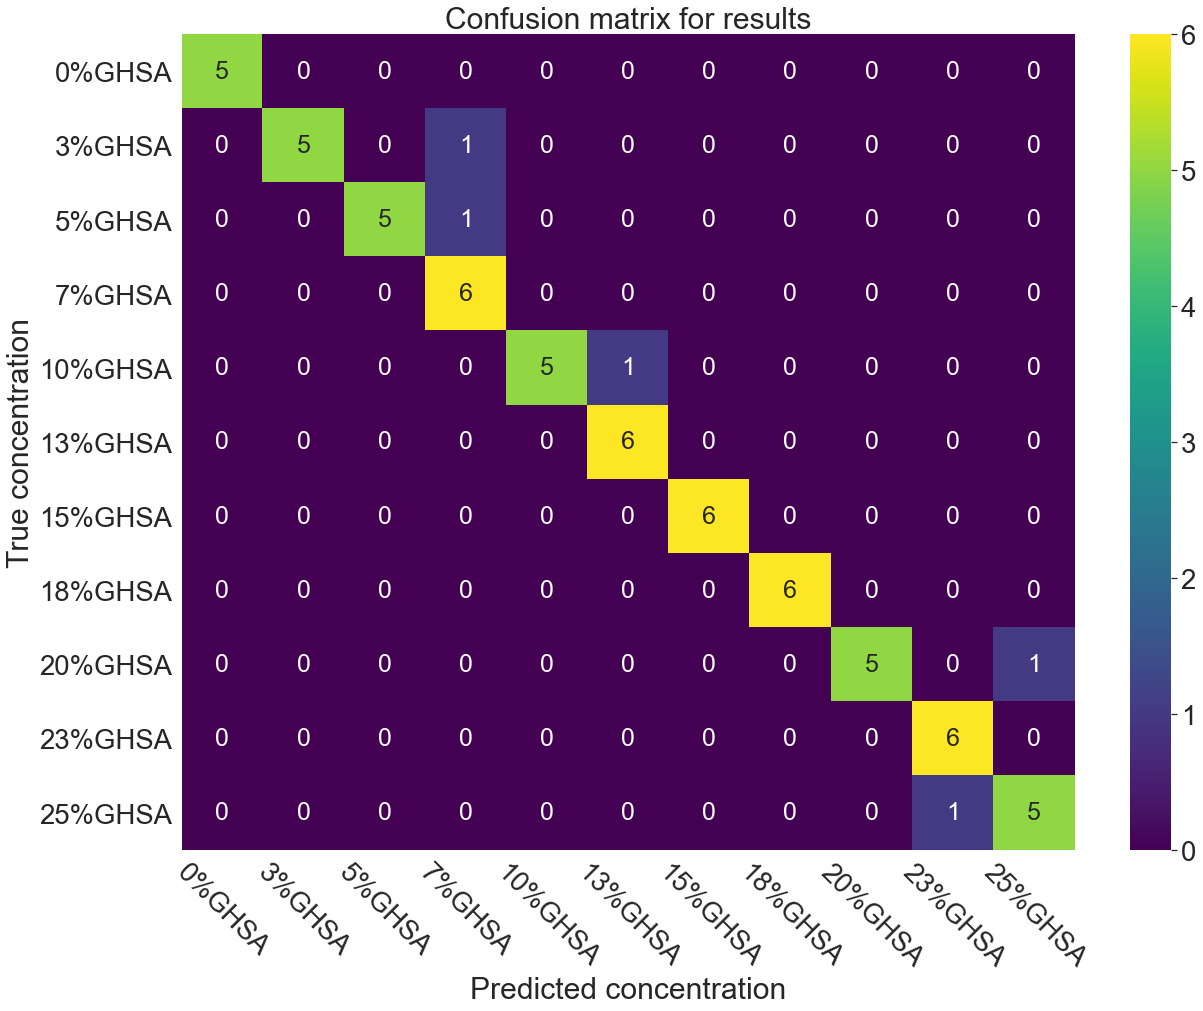

In [92]:
z =confusion_matrix(list(y_test[:,0]), list(y_pred))


array = z

df_cm = pd.DataFrame(array, x, x)
plt.figure(figsize=(20,15))
sn.set(font_scale=2.5) # for label size
ax = sn.heatmap(df_cm, annot=True,cmap = 'viridis', annot_kws={"size": 25}) # font size
                 
ax.set_ylabel("True concentration")
ax.set_xlabel("Predicted concentration") 
plt.xticks(rotation=-45)
plt.title('Confusion matrix for results')
plt.show()



## Loadings

In [93]:
fig = go.Figure()

k = 50
spisok  = [1,2,5]
for klass in (np.arange(0,11)):
    
    for elem in [all_data[5]]:
        title = elem[elem.label == klass].conc.iloc[0][:-24]
        y = (k+((lda.coef_[klass,:]))[:-20])
        fig.add_trace(go.Scatter(
                                 y= savgol_filter(y,15,3),
                       mode='lines',name = title))

        k = k-500


        fig.update_xaxes(title_text = '$$ {Raman shift} \;\; (cm^{-1})  $$')
        fig.update_yaxes(title_text='Loadings')
        fig.update_layout(   font=dict(
        size=20
    )
)


fig.show()


## Latent space on train

In [94]:

Xlda = lda.transform((X_train) )
dataaa = pd.DataFrame(Xlda, columns = ['F1','F2','F3'])
dataaa['classes'] = y_train[:,0]
dataaa['col'] = list(y_train[:,2])
fig = px.scatter(dataaa, x='F1', y='F2', color = [x[:-24] for x in y_train[:,2]], title='Train')
fig.update_layout(   font=dict(
        size=20
    )
)
fig.show()